### Libraries

In [10]:
import os
import numpy as np
import pandas as pd
from nitime.timeseries import TimeSeries
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy import stats

### Read data

In [11]:
# Example fMRI time-series data (timepoints x ROIs)
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Amsterdam-VUmc_sub-916002/Amsterdam-VUmc_sub-916002.npy")
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Seoul-SNU_sub-DNO01LYH/Seoul-SNU_sub-DNO01LYH.npy")
# time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Brazil_sub-P00196820141124/Brazil_sub-P00196820141124.npy")

print(f"Data shape: {time_series_data.shape}")

Data shape: (112, 316)


In [12]:
y = time_series_data.T # [180, seq_len]
ts_length = y.shape[1]
TR = 3.5   # EDIT the TR
print(f"y shape: {y.shape}")

y shape: (316, 112)


### Fixed cutoffs

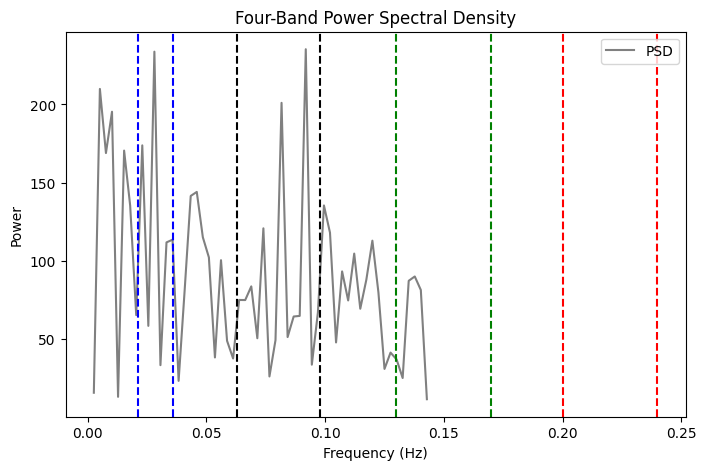

xdata.shape: (56,), ydata.shape: (56,)


In [13]:
sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec   

T = TimeSeries(sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata, label='PSD', linewidth=1.5, color='gray')

# Add dashed vertical lines at f1 and f2
plt.axvline(x=0.24, color='red', linestyle='--')
plt.axvline(x=0.20, color='red', linestyle='--')            
plt.axvline(x=0.17, color='green', linestyle='--')
plt.axvline(x=0.13, color='green', linestyle='--')
plt.axvline(x=0.098, color='black', linestyle='--')
plt.axvline(x=0.063, color='black', linestyle='--')
plt.axvline(x=0.036, color='blue', linestyle='--')
plt.axvline(x=0.021, color='blue', linestyle='--')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("Four-Band Power Spectral Density")
# plt.grid(True, linestyle='--', alpha=0.7)
plt.grid(False)
plt.legend()
plt.show()

print(f"xdata.shape: {xdata.shape}, ydata.shape: {ydata.shape}")

Nyquist frequency: 0.14285714285714285


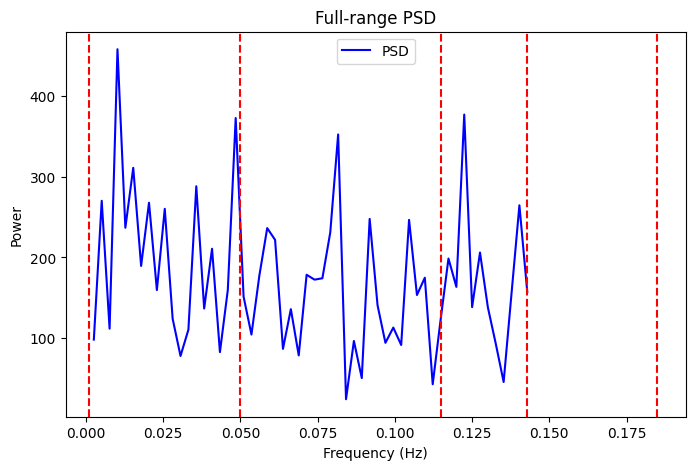

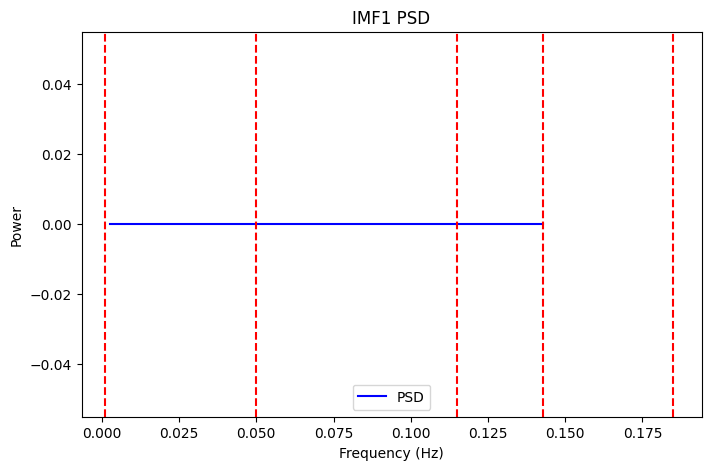

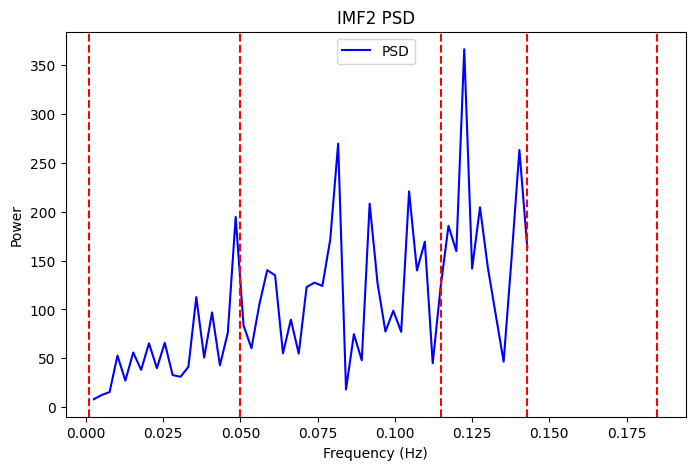

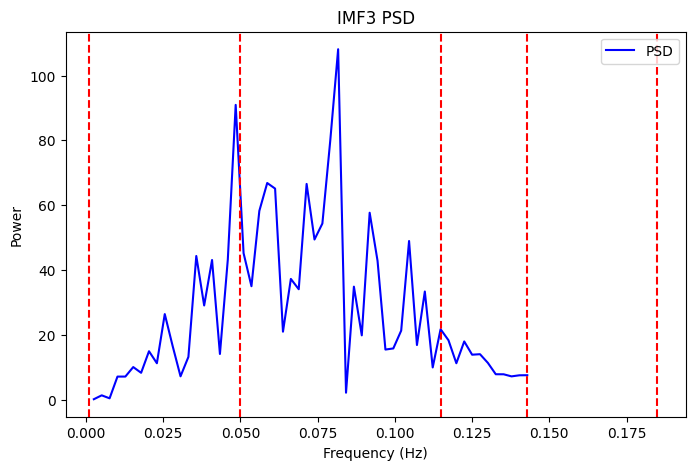

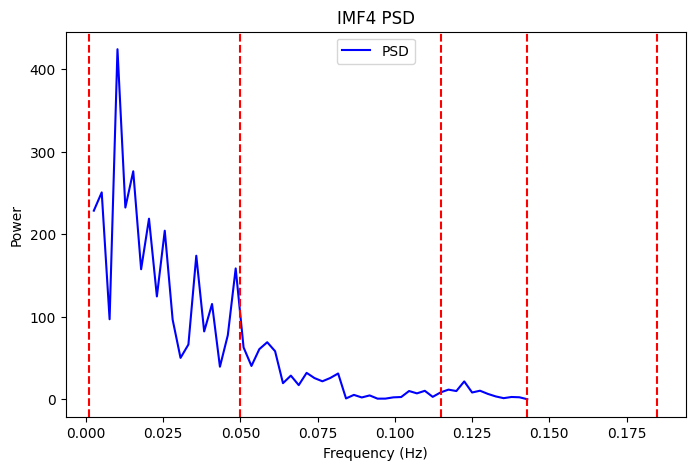

In [25]:
nyquist_freq = 1/(2*TR)
print(f"Nyquist frequency: {nyquist_freq}")

# Full-range time series
T = TimeSeries(y, sampling_interval=TR)
S_original1 = SpectralAnalyzer(T)  # creates a spectral analyzer object for the time-series data T1
xdata = np.array(S_original1.spectrum_fourier[0][1:])
ydata = np.abs(S_original1.spectrum_fourier[1][:,1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata[0,:], label='PSD', linewidth=1.5, color='blue')  # first ROI
# Add dashed vertical lines at f1 and f2
plt.axvline(x=1/(2*TR), color='red', linestyle='--')
plt.axvline(x=0.185, color='red', linestyle='--')            
plt.axvline(x=0.115, color='red', linestyle='--')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=0.001, color='red', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("Full-range PSD")
plt.grid(False)
plt.legend()
plt.show()

# VMD IMF1: 0.20-0.24 Hz
if nyquist_freq > 0.185:
    lower_bound = 0.185
    upper_bound = 1 / (2*TR)
    T1 = TimeSeries(y, sampling_interval=TR)  # creates a time-series object from y
    FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
    imf_1 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)
    imf_2_4 = FA1.data-FA1.filtered_boxcar.data
else: # filter out the whole band
    T1 = TimeSeries(np.zeros(y.shape), sampling_interval=TR)
    FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
    imf_1 = T1  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)
    imf_2_4 = y

T = TimeSeries(FA1.filtered_boxcar.data, sampling_interval=TR)
S_original1 = SpectralAnalyzer(T)  # creates a spectral analyzer object for the time-series data T1
xdata = np.array(S_original1.spectrum_fourier[0][1:])
ydata = np.abs(S_original1.spectrum_fourier[1][:,1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata[0,:], label='PSD', linewidth=1.5, color='blue')  # first ROI
# Add dashed vertical lines at f1 and f2
plt.axvline(x=1/(2*TR), color='red', linestyle='--')
plt.axvline(x=0.185, color='red', linestyle='--')            
plt.axvline(x=0.115, color='red', linestyle='--')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=0.001, color='red', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("IMF1 PSD")
plt.grid(False)
plt.legend()
plt.show()


# VMD IMF2: 0.13-0.17 Hz
lower_bound = 0.115
upper_bound = max(0.185, nyquist_freq)
T1 = TimeSeries(imf_2_4, sampling_interval=TR)  # creates a time-series object from y
FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
imf_2 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)
imf_3_4 = FA1.data-FA1.filtered_boxcar.data

T = TimeSeries(FA1.filtered_boxcar.data, sampling_interval=TR)
S_original1 = SpectralAnalyzer(T)  # creates a spectral analyzer object for the time-series data T1
xdata = np.array(S_original1.spectrum_fourier[0][1:])
ydata = np.abs(S_original1.spectrum_fourier[1][:,1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata[0,:], label='PSD', linewidth=1.5, color='blue')  # first ROI
# Add dashed vertical lines at f1 and f2
plt.axvline(x=1/(2*TR), color='red', linestyle='--')
plt.axvline(x=0.185, color='red', linestyle='--')            
plt.axvline(x=0.115, color='red', linestyle='--')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=0.001, color='red', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("IMF2 PSD")
plt.grid(False)
plt.legend()
plt.show()

# VMD IMF3: 0.063- 0.098 Hz
lower_bound = 0.05
upper_bound = 0.115
T1 = TimeSeries(imf_3_4, sampling_interval=TR)  # creates a time-series object from y
S_original = SpectralAnalyzer(T1)
FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
imf_3 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)
imf_4 = FA1.data-FA1.filtered_boxcar.data

T = TimeSeries(FA1.filtered_boxcar.data, sampling_interval=TR)
S_original1 = SpectralAnalyzer(T)  # creates a spectral analyzer object for the time-series data T1
xdata = np.array(S_original1.spectrum_fourier[0][1:])
ydata = np.abs(S_original1.spectrum_fourier[1][:,1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata[0,:], label='PSD', linewidth=1.5, color='blue')  # first ROI
# Add dashed vertical lines at f1 and f2
plt.axvline(x=1/(2*TR), color='red', linestyle='--')
plt.axvline(x=0.185, color='red', linestyle='--')            
plt.axvline(x=0.115, color='red', linestyle='--')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=0.001, color='red', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("IMF3 PSD")
plt.grid(False)
plt.legend()
plt.show()


# VMD IMF4: 0.021-0.036 Hz
lower_bound = 0.001
upper_bound = 0.05
T1 = TimeSeries(imf_4, sampling_interval=TR)  # creates a time-series object from y
S_original = SpectralAnalyzer(T1)
FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
imf_4 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)

T = TimeSeries(FA1.filtered_boxcar.data, sampling_interval=TR)
S_original1 = SpectralAnalyzer(T)  # creates a spectral analyzer object for the time-series data T1
xdata = np.array(S_original1.spectrum_fourier[0][1:])
ydata = np.abs(S_original1.spectrum_fourier[1][:,1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata[0,:], label='PSD', linewidth=1.5, color='blue')  # first ROI
# Add dashed vertical lines at f1 and f2
plt.axvline(x=1/(2*TR), color='red', linestyle='--')
plt.axvline(x=0.185, color='red', linestyle='--')            
plt.axvline(x=0.115, color='red', linestyle='--')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=0.001, color='red', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("IMF4 PSD")
plt.grid(False)
plt.legend()
plt.show()

### Variational Mode Decomposition (for each ROI)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def vmd(signal, alpha, tau, K, tol, max_iter, TR):
    """
    Variational Mode Decomposition (VMD) with TR adjustment.

    Parameters:
    signal: ndarray - Input signal (1D array).
    alpha: float - Bandwidth constraint parameter.
    tau: float - Time-step for dual ascent.
    K: int - Number of modes to extract.
    tol: float - Convergence tolerance.
    max_iter: int - Maximum number of iterations.
    TR: float - Repetition Time (sampling interval in seconds).

    Returns:
    modes: ndarray - Decomposed modes (K x len(signal)).
    center_frequencies: ndarray - Center frequencies of each mode.
    """
    length = len(signal)
    f_hat = np.fft.fft(signal)  # Fourier transform of the signal
    omega = np.fft.fftfreq(length, d=TR)  # Frequency grid scaled by TR
    u_hat = np.zeros((K, length), dtype=complex)  # Modes in Fourier domain
    lambda_hat = np.zeros(length, dtype=complex)  # Dual variables in Fourier domain

    for n in range(max_iter):
        u_hat_prev = np.copy(u_hat)
        for k in range(K):
            residual = f_hat - np.sum(u_hat[:k], axis=0) - np.sum(u_hat_prev[k+1:], axis=0)
            u_hat[k] = (residual + lambda_hat / 2) / (1 + 2 * alpha * (omega - omega[k])**2)
            omega[k] = np.sum(omega * np.abs(u_hat[k])**2) / np.sum(np.abs(u_hat[k])**2)
        lambda_hat += tau * (f_hat - np.sum(u_hat, axis=0))
        if np.sum([np.linalg.norm(u_hat[k] - u_hat_prev[k]) / np.linalg.norm(u_hat_prev[k]) for k in range(K)]) < tol:
            break

    modes = np.fft.ifft(u_hat, axis=1).real
    return modes, omega


# Modified function for multi-ROI time series
def vmd_multi_roi(data, alpha, tau, K, tol, max_iter):
    """
    Apply VMD to multi-ROI time series data.

    Parameters:
    data: ndarray - Input data of shape (# of ROIs, # of timepoints).
    alpha: float - Bandwidth constraint parameter.
    tau: float - Time-step for dual ascent.
    K: int - Number of modes to extract.
    tol: float - Convergence tolerance.
    max_iter: int - Maximum number of iterations.

    Returns:
    all_modes: list - List of decomposed modes for each ROI.
    all_frequencies: list - List of center frequencies for each ROI.
    """
    num_rois, num_timepoints = data.shape
    all_modes = []
    all_frequencies = []

    for roi in range(num_rois):
        signal = data[roi]
        modes, frequencies = vmd(signal, alpha, tau, K, tol, max_iter)
        all_modes.append(modes)
        all_frequencies.append(frequencies)

    return all_modes, all_frequencies

# Example application to multi-ROI data
if __name__ == "__main__":
    np.random.seed(42)
    num_rois = 3
    length = 500
    t = np.linspace(0, 1, length, endpoint=False)

    # Simulated multi-ROI data: Combination of sine waves for each ROI
    data = np.array([
        np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 20 * t) + 0.5 * np.random.randn(length),
        np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 15 * t) + 0.5 * np.random.randn(length),
        np.sin(2 * np.pi * 3 * t) + np.sin(2 * np.pi * 25 * t) + 0.5 * np.random.randn(length),
    ])

    # Apply VMD
    alpha = 2000  # Bandwidth constraint
    tau = 0  # Dual ascent time-step
    K = 3  # Number of modes
    tol = 1e-6  # Convergence tolerance
    max_iter = 500  # Maximum iterations

    all_modes, all_frequencies = vmd_multi_roi(data, alpha, tau, K, tol, max_iter)

    # Plot results for the first ROI
    plt.figure(figsize=(12, 8))
    plt.subplot(K + 1, 1, 1)
    plt.plot(t, data[0])
    plt.title("Original Signal (ROI 1)")
    for i in range(K):
        plt.subplot(K + 1, 1, i + 2)
        plt.plot(t, all_modes[0][i])
        plt.title(f"Mode {i + 1} (Center Frequency: {all_frequencies[0][i]:.2f})")
    plt.tight_layout()
    plt.show()